In [37]:
import matplotlib
from matplotlib import pyplot as plt
import torch
import numpy as np
import scipy
import sklearn
import sklearn.metrics
import math
import uproot
import xgboost as xgb
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='monokai', ticks=True, context="talk", gridlines='--')

In [29]:
data = uproot.open("/Users/vinayakkapoor/Desktop/Top Quark Research/Initial State Classification/ee_modified_root_1_long.root")

In [47]:
data = uproot.open("/Users/vinayakkapoor/Desktop/Top Quark Research/Initial State Classification/mumu_modified_root_1_long.root")


In [49]:
tree = data['ttBar_treeVariables_step8;40;1']

In [50]:
tree

<TTree 'ttBar_treeVariables_step8;40' (83 branches) at 0x7fa999b0f4c0>

In [51]:
ones_mask = tree['production_mode'].array(library='numpy') == 1
zeros_mask = tree['production_mode'].array(library='numpy') == 0

In [52]:
X_ones = torch.cat([torch.from_numpy(tree[key].array(library='numpy')[ones_mask][:, None]).float() for key in tree.keys() if (key != 'production_mode' and key != 'eventWeight' and key != '__index__')], dim=1) 

X_zeros = torch.cat([torch.from_numpy(tree[key].array(library='numpy')[zeros_mask][:, None]).float() for key in tree.keys() if (key != 'production_mode' and key != 'eventWeight' and key != '__index__')], dim=1) 


In [53]:
train_split = 0.7 # 70% of the data is training
valid_split = 0.2 # 20% of the data is validation
test_split = 0.1 # 10% of the data is testing

num_ones = len(X_ones) # calculate total number of data points with class labels = 1
num_zeros = len(X_zeros) # calculate total number of data points with class labels = 0

# split the data into training data
training_data = torch.cat((X_ones[:math.ceil(num_ones * train_split)], X_zeros[:math.ceil(num_zeros * train_split)]))
# split the labels for just training data
training_labels = torch.cat((torch.ones(math.ceil(num_ones * train_split)), torch.zeros(math.ceil(num_zeros * train_split))))

# split the data into validation data
validation_data = torch.cat((X_ones[math.ceil(num_ones * train_split):math.ceil(num_ones * (train_split + valid_split))],
                             X_zeros[math.ceil(num_zeros * train_split):math.ceil(num_zeros * (train_split + valid_split))]))
validation_labels = torch.cat((torch.ones(math.ceil(num_ones * valid_split)), torch.zeros(math.ceil(num_zeros * valid_split))))

# split the data into testing data
test_data = torch.cat((X_ones[math.ceil(num_ones * (train_split + valid_split)):],
                      X_zeros[math.ceil(num_zeros * (train_split + valid_split)):]))
test_labels = torch.cat((torch.ones(len(X_ones[math.ceil(num_ones * (train_split + valid_split)):])),
                        torch.zeros(len(X_zeros[math.ceil(num_zeros * (train_split + valid_split)):]))))

In [54]:
num_ones_in_training = int(train_split * num_ones)
num_zeros_in_training = int(train_split * num_zeros)

# upsample the training data
if num_ones_in_training > num_zeros_in_training: # need to upsample the zeros
    multiplicity = math.ceil(num_ones_in_training / num_zeros_in_training)
    
    training_data = torch.cat((training_data[training_labels == 1], training_data[training_labels == 0].repeat(multiplicity, 1)[:num_ones_in_training]))
    training_labels = torch.cat((training_labels[training_labels == 1][:num_zeros_in_training], training_labels[training_labels == 0].repeat(multiplicity)[:num_ones_in_training]))
elif num_zeros_in_training > num_ones_in_training: # need to upsample the ones
    multiplicity = math.ceil(num_zeros_in_training / num_ones_in_training)
    
    training_data = torch.cat((training_data[training_labels == 1].repeat(multiplicity, 1)[:num_zeros_in_training], training_data[training_labels == 0]))
    training_labels = torch.cat((training_labels[training_labels == 1].repeat(multiplicity)[:num_zeros_in_training], training_labels[training_labels == 0]))

In [55]:
num_ones_in_validation = len(validation_labels[validation_labels == 1])
num_zeros_in_validation = len(validation_labels[validation_labels == 0])

# upsample the validation data
if num_ones_in_validation > num_zeros_in_validation: # need to upsample the zeros
    multiplicity = math.ceil(num_ones_in_validation / num_zeros_in_validation)
    
    validation_data = torch.cat((validation_data[validation_labels == 1], validation_data[validation_labels == 0].repeat(multiplicity, 1)[:num_ones_in_validation]))
    validation_labels = torch.cat((validation_labels[validation_labels == 1][:num_zeros_in_validation], validation_labels[validation_labels == 0].repeat(multiplicity)[:num_ones_in_validation]))
elif num_zeros_in_validation > num_ones_in_validation: # need to upsample the ones
    multiplicity = math.ceil(num_zeros_in_validation / num_ones_in_validation)
    
    validation_data = torch.cat((validation_data[validation_labels == 1].repeat(multiplicity, 1)[:num_zeros_in_validation], validation_data[validation_labels == 0]))
    validation_labels = torch.cat((validation_labels[validation_labels == 1].repeat(multiplicity)[:num_zeros_in_validation], validation_labels[validation_labels == 0]))

In [56]:
# standardize the data
standardized_training_data = (training_data - torch.mean(training_data, 0)) / torch.std(training_data, 0, True)
standardized_validation_data = (validation_data - torch.mean(validation_data, 0)) / torch.std(validation_data, 0, True)
standardized_testing_data = (test_data - torch.mean(test_data, 0)) / torch.std(test_data, 0, True)

# replace nans with 0 for zero width values
standardized_training_data = torch.nan_to_num(standardized_training_data, nan=0.0, posinf=0.0, neginf=0.0)
standardized_validation_data = torch.nan_to_num(standardized_validation_data, nan=0.0, posinf=0.0, neginf=0.0)
standardized_testing_data = torch.nan_to_num(standardized_testing_data, nan=0.0, posinf=0.0, neginf=0.0)

In [57]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt


xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0,max_depth=5,reg_alpha = 10, n_estimators = 300,learning_rate = 0.01)
xgb_model.fit(standardized_training_data, training_labels)

/Users/vinayakkapoor/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:

# Make predictions on the test set
y_pred_proba_train = xgb_model.predict_proba(standardized_training_data)[:,1]
y_pred_proba_valid = xgb_model.predict_proba(standardized_validation_data)[:,1]



In [59]:
train_auc = roc_auc_score(training_labels, y_pred_proba_train)
valid_auc = roc_auc_score(validation_labels, y_pred_proba_valid)

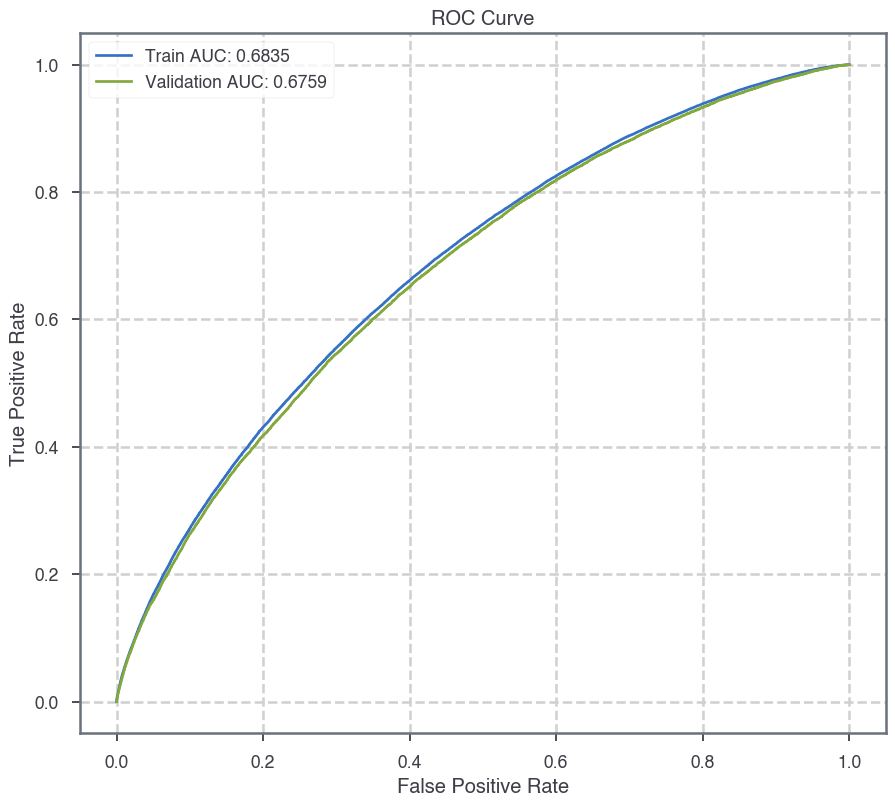

In [60]:
# Plot the ROC curve
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3', ticks=True, context="talk", gridlines='--')
fpr_valid, tpr_valid, thresholds = roc_curve(validation_labels, y_pred_proba_valid,)
fpr_train, tpr_train, thresholds = roc_curve(training_labels, y_pred_proba_train,)

plt.plot(fpr_train, tpr_train, label=f'Train AUC: {train_auc:.4f}')
plt.plot(fpr_valid, tpr_valid, label=f'Validation AUC: {valid_auc:.4f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [14]:
auc

0.6813011268952731

In [15]:
# Make predictions on the test set
y_pred_proba = xgb_model.predict_proba(standardized_training_data)[:,1]

# Calculate the AUC
auc = roc_auc_score(training_labels, y_pred_proba)

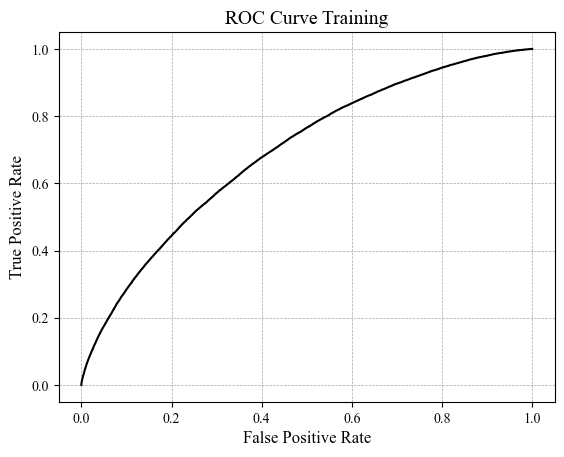

In [16]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(training_labels, y_pred_proba,)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'black')
ax.grid(linestyle='--', linewidth='0.5', color='gray', alpha=0.7)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)

ax.set_title('ROC Curve Training', fontsize=14)

# Show the plot
plt.show()


In [17]:
auc

0.6940328563222711

In [18]:
# Make predictions on the test set
y_pred_proba = xgb_model.predict_proba(standardized_testing_data)[:,1]

# Calculate the AUC
auc = roc_auc_score(test_labels, y_pred_proba)

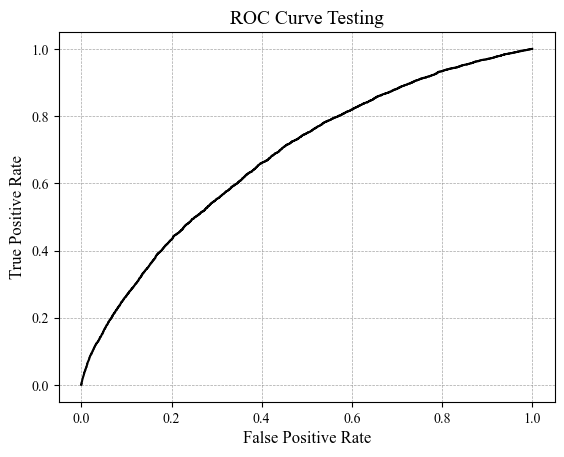

In [19]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba,)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'black')
ax.grid(linestyle='--', linewidth='0.5', color='gray', alpha=0.7)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)

ax.set_title('ROC Curve Testing', fontsize=14)

# Show the plot
plt.show()


In [20]:
auc

0.6800782478893912

In [93]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05,0.01],
    #learning rate increase exponentially 
    'n_estimators': [100, 200,300],
    #'subsample': [0.8, 1],
    #'colsample_bytree': [0.8, 1],
    'reg_alpha': [0.1, 1, 10],
}
#lasso

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic")

# Create the grid search object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
xgb_model.fit(standardized_training_data, training_labels)

/Users/vinayakkapoor/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

In [ ]:
grid_search.fit(standardized_training_data, training_labels)
print("Best parameters:", grid_search.best_params_)
print("Best AUC-ROC score:", grid_search.best_score_)

In [ ]:
#save intermediate results 
#save model, predictions
#save training loss
#repeat gridsearch


Epoch: 1 	Training Loss: 0.643136 	Training AUC: 0.677576 	Validation Loss: 0.642047 	Validation AUC: 0.679920


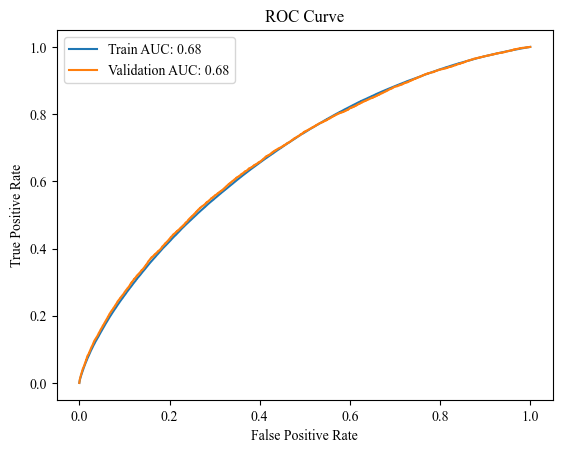

Epoch: 2 	Training Loss: 0.639978 	Training AUC: 0.682783 	Validation Loss: 0.641583 	Validation AUC: 0.680458


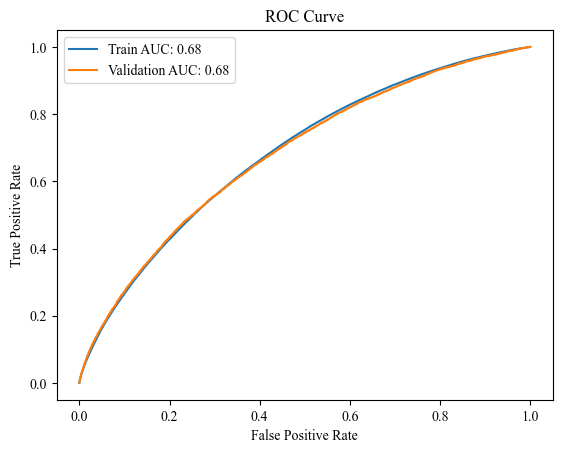

Epoch: 3 	Training Loss: 0.639382 	Training AUC: 0.683593 	Validation Loss: 0.641901 	Validation AUC: 0.681241


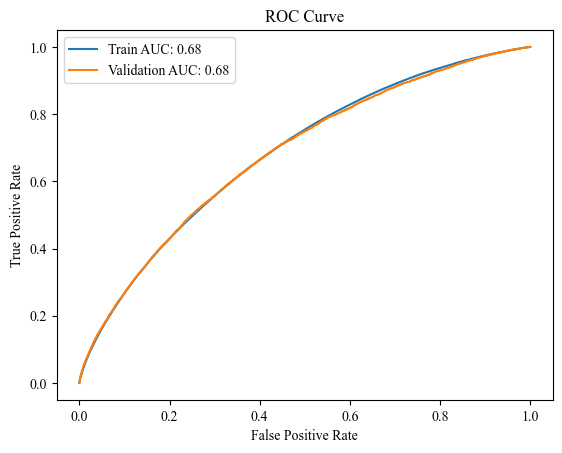

Epoch: 4 	Training Loss: 0.639043 	Training AUC: 0.684204 	Validation Loss: 0.640682 	Validation AUC: 0.681833


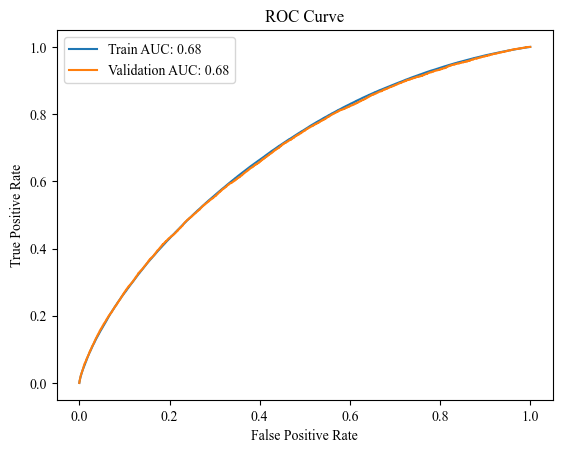

Epoch: 5 	Training Loss: 0.638766 	Training AUC: 0.684414 	Validation Loss: 0.641142 	Validation AUC: 0.681418


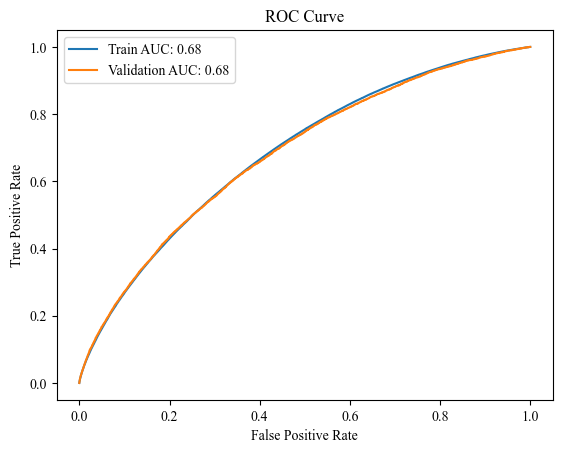

Epoch: 6 	Training Loss: 0.638686 	Training AUC: 0.684634 	Validation Loss: 0.641292 	Validation AUC: 0.681061


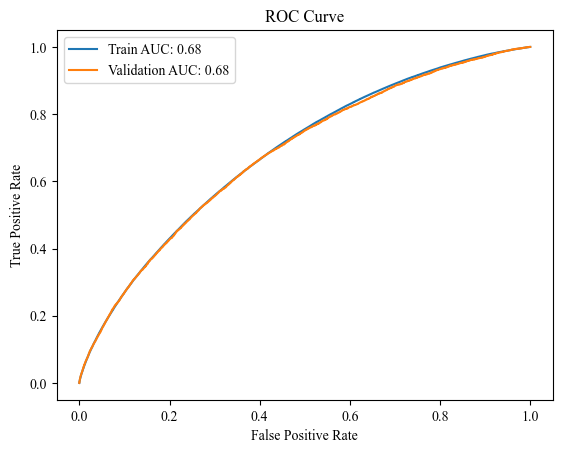

Epoch: 7 	Training Loss: 0.638648 	Training AUC: 0.684723 	Validation Loss: 0.640693 	Validation AUC: 0.682036


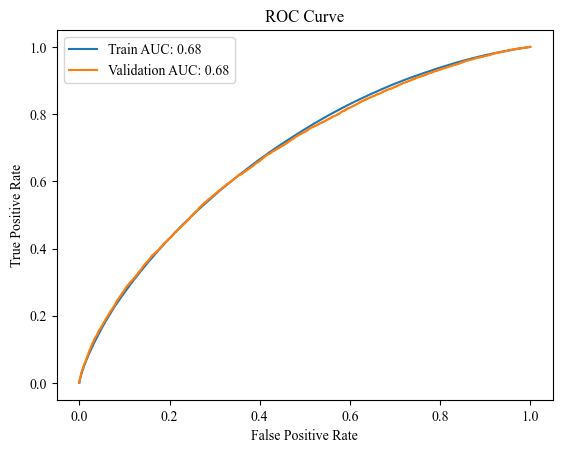

Epoch: 8 	Training Loss: 0.638678 	Training AUC: 0.684636 	Validation Loss: 0.641302 	Validation AUC: 0.680906


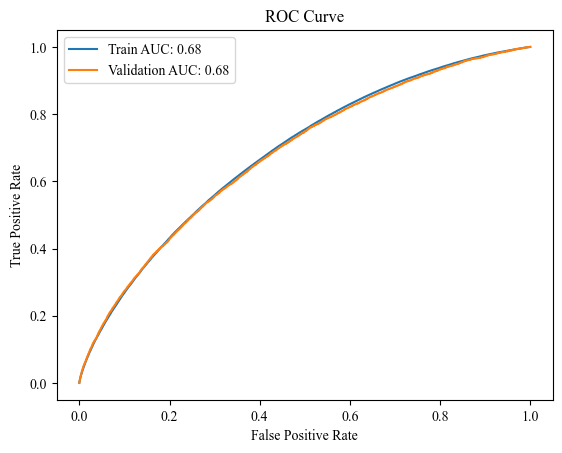

Epoch: 9 	Training Loss: 0.638698 	Training AUC: 0.684603 	Validation Loss: 0.646760 	Validation AUC: 0.679385


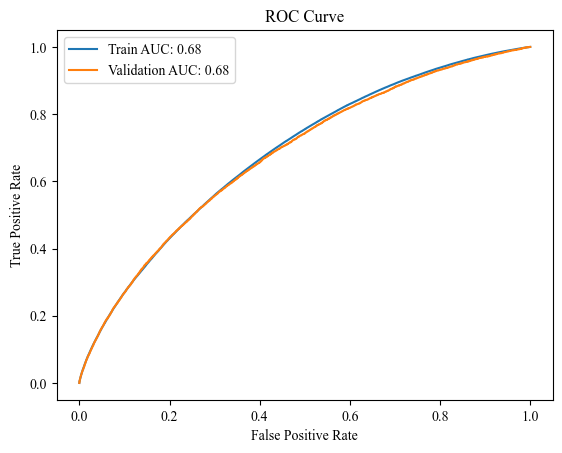

Epoch: 10 	Training Loss: 0.638700 	Training AUC: 0.684674 	Validation Loss: 0.640944 	Validation AUC: 0.681079


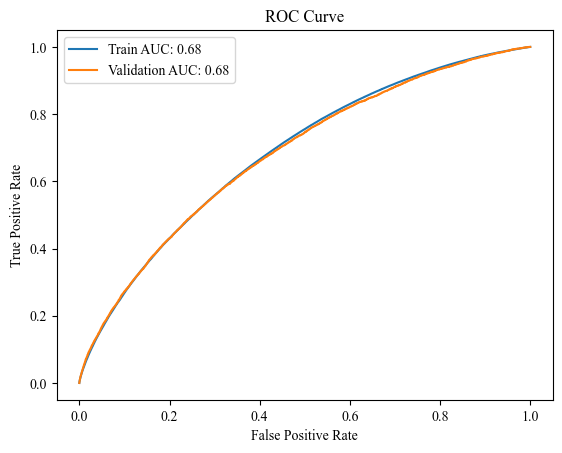

Epoch: 11 	Training Loss: 0.638534 	Training AUC: 0.684838 	Validation Loss: 0.641195 	Validation AUC: 0.680501


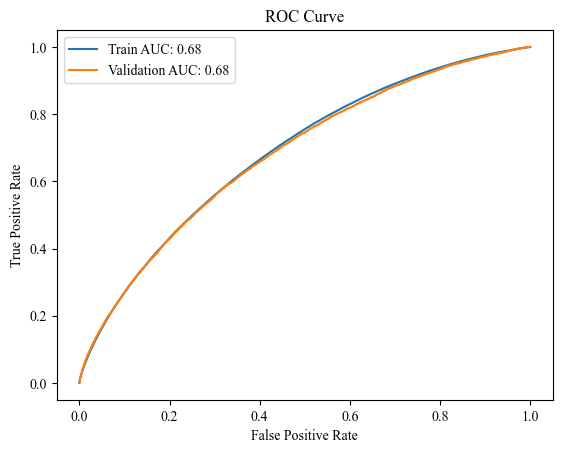

Epoch: 12 	Training Loss: 0.638739 	Training AUC: 0.684660 	Validation Loss: 0.641184 	Validation AUC: 0.681059


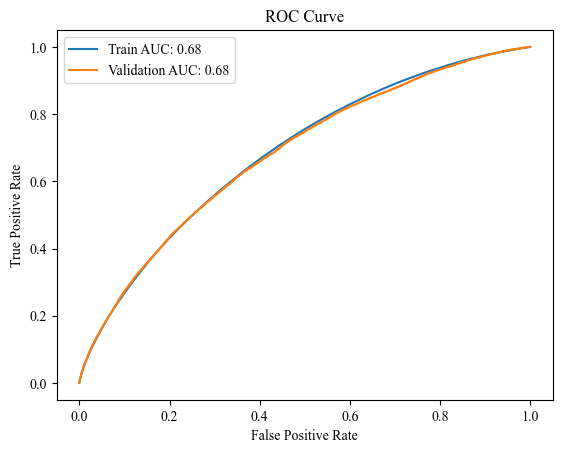

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Define the model architecture
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

# Define the dataset and data loaders
train_dataset = TensorDataset(torch.Tensor(standardized_training_data), torch.Tensor(training_labels).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(torch.Tensor(standardized_validation_data), torch.Tensor(validation_labels).unsqueeze(1))
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(standardized_testing_data), torch.Tensor(test_labels).unsqueeze(1))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Create the model and define the loss and optimizer
model = BinaryClassifier(standardized_training_data.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # Add L1 penalty with weight_decay parameter

# Train the model
for epoch in range(50):
    train_loss = 0.0
    valid_loss = 0.0
    y_true_train = []
    y_pred_train = []
    y_true_valid = []
    y_pred_valid = []
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        y_true_train.extend(target.cpu().numpy())
        y_pred_train.extend(output.detach().numpy())

    train_loss /= len(train_loader.dataset)
    train_auc = roc_auc_score(y_true_train, y_pred_train)
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_train)

    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            y_true_valid.extend(target.cpu().numpy())
            y_pred_valid.extend(output.detach().numpy())

        valid_loss /= len(valid_loader.dataset)
        valid_auc = roc_auc_score(y_true_valid, y_pred_valid)
        fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_pred_valid)

    print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTraining AUC: {train_auc:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation AUC: {valid_auc:.6f}")
    plt.plot(fpr_train, tpr_train, label=f'Train AUC: {train_auc:.2f}')
    plt.plot(fpr_valid, tpr_valid, label=f'Validation AUC: {valid_auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# Evaluate the model on the test set
test_loss = 0.0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        predicted = torch.round(output)
        correct += (predicted == target).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100.0 * correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.6f} \tTest Accuracy: {test_accuracy:.2f}%")
